In [1]:
from __future__ import absolute_import,division,print_function

In [2]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

In [3]:
print(tf.__version__)
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras import layers
print(hub.__version__)

2.1.0
0.7.0


In [4]:
(training_set,validation_set),dataset_info = tfds.load(
    'tf_flowers',
    split = ['train[:70%]','train[70%:]'],
    with_info = True,
    as_supervised = True,
)

In [5]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
    num_training_examples += 1
    
for example in validation_set:
    num_validation_examples += 1
    
print("Number of Classes : {}".format(num_classes))
print("Numbber of training examples: {}".format(num_training_examples))
print('Number of validation examples: {}'.format(num_validation_examples))

Number of Classes : 5
Numbber of training examples: 2569
Number of validation examples: 1101


In [6]:
for i,example in enumerate(training_set.take(5)):
    print('Image {} shape: {} label: {}'.format(i+1,example[0].shape,example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [7]:
IMAGE_RES = 224

def format_image(image,label):
    image = tf.image.resize(image ,(IMAGE_RES,IMAGE_RES))/255.0
    return image,label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [8]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extracter = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES,IMAGE_RES,3))

In [9]:
feature_extracter.trainable = False

In [10]:
model = tf.keras.Sequential([
        feature_extracter,
        layers.Dense(num_classes)
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
model.compile(
    optimizer = 'adam',
    loss  = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)
EPOCHS = 6

history = model.fit(train_batches,
                    epochs = EPOCHS,
                    validation_data = validation_batches)

Epoch 1/6
81/81 [==============================] - 100s 1s/step - loss: 0.3866 - accuracy: 0.8684 - val_loss: 0.3426 - val_accuracy: 0.8765
Epoch 2/6
81/81 [==============================] - 92s 1s/step - loss: 0.2811 - accuracy: 0.9081 - val_loss: 0.3305 - val_accuracy: 0.8892
Epoch 3/6
81/81 [==============================] - 91s 1s/step - loss: 0.2322 - accuracy: 0.9284 - val_loss: 0.2957 - val_accuracy: 0.8974
Epoch 4/6
81/81 [==============================] - 91s 1s/step - loss: 0.1998 - accuracy: 0.9416 - val_loss: 0.2830 - val_accuracy: 0.9037
Epoch 5/6
81/81 [==============================] - 93s 1s/step - loss: 0.1728 - accuracy: 0.9548 - val_loss: 0.2786 - val_accuracy: 0.9074
Epoch 6/6
81/81 [==============================] - 91s 1s/step - loss: 0.1492 - accuracy: 0.9638 - val_loss: 0.2903 - val_accuracy: 0.8919


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Unrecognized location 'upeer left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


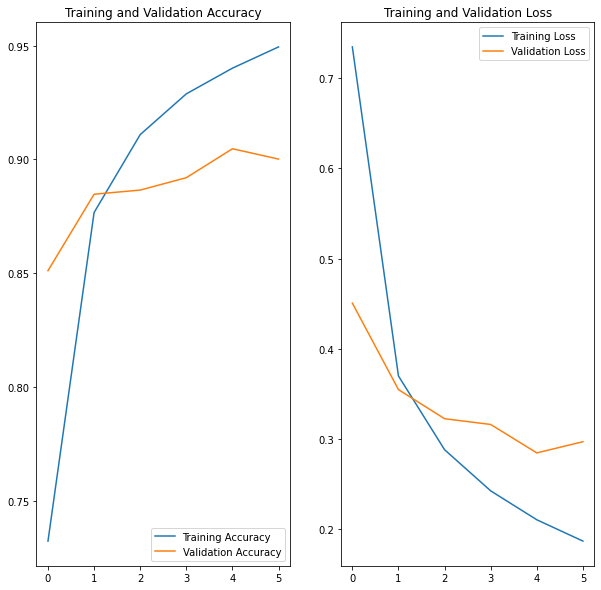

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label = "Training Accuracy")
plt.plot(epochs_range,val_acc,label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label = "Training Loss")
plt.plot(epochs_range,val_loss,label = "Validation Loss")
plt.legend(loc = 'upeer left')
plt.title("Training and Validation Loss")
plt.show()

In [14]:
import numpy as np
class_name = np.array(dataset_info.features['label'].names)
print(class_name)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [15]:
image_batch,label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch,axis = -1)
predicted_class_names = class_name[predicted_ids]

print(predicted_class_names)
print(predicted_ids)

['dandelion' 'dandelion' 'tulips' 'dandelion' 'daisy' 'tulips'
 'sunflowers' 'dandelion' 'dandelion' 'dandelion' 'tulips' 'roses'
 'dandelion' 'sunflowers' 'dandelion' 'tulips' 'dandelion' 'dandelion'
 'sunflowers' 'daisy' 'dandelion' 'sunflowers' 'daisy' 'dandelion' 'daisy'
 'sunflowers' 'roses' 'daisy' 'dandelion' 'sunflowers' 'tulips' 'roses']
[0 0 2 0 1 2 3 0 0 0 2 4 0 3 0 2 0 0 3 1 0 3 1 0 1 3 4 1 0 3 2 4]


In [16]:
print("Labels:  ",label_batch)
print("Predicted labels:  ",predicted_ids)

Labels:   [0 0 2 0 1 2 3 0 0 0 2 4 0 3 0 2 0 0 3 1 0 3 1 0 1 3 4 1 0 3 2 4]
Predicted labels:   [0 0 2 0 1 2 3 0 0 0 2 4 0 3 0 2 0 0 3 1 0 3 1 0 1 3 4 1 0 3 2 4]


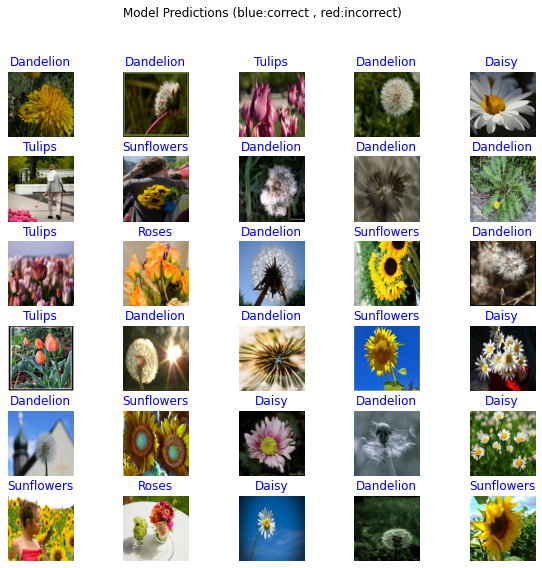

In [17]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(),color = color)
  plt.axis('off')
  _ = plt.suptitle("Model Predictions (blue:correct , red:incorrect)")
